# Quora question pair 

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>

__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

# 1. Eaxmple data points

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

# 1.2 Performance Metric

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

In [ ]:
# import libraries
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string

import pickle

from tqdm import tqdm
import os

!pip install chart_studio
#from plotly import plotly
#import plotly.offline as offline
#import plotly.graph_objs as go

import chart_studio.plotly as py
import plotly.graph_objs as go
from collections import Counter

from prettytable import PrettyTable

In [ ]:
# load google drive mount 
from google.colab import drive
drive.mount('/content/drive')

# load dataset 
data = pd.read_csv("/content/drive/MyDrive/collab_data/Quora/train.csv")

Mounted at /content/drive


In [ ]:
data.head(1)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0


## 2.1 Dataset overview

In [ ]:
print("Number of data points in train data set: ", data.shape)

Number of data points in train data set:  (404290, 6)


In [ ]:
print("Attributes of the dataset:", data.columns.values)

Attributes of the dataset: ['id' 'qid1' 'qid2' 'question1' 'question2' 'is_duplicate']


In [ ]:
# No of pair questions is duplicate
is_duplicate = data['is_duplicate'].value_counts()
print(is_duplicate)

0    255027
1    149263
Name: is_duplicate, dtype: int64


In [ ]:
duplicate = len(data.loc[ (data['is_duplicate']==1)])
not_duplicate = len(data.loc[ (data['is_duplicate'] ==0)])

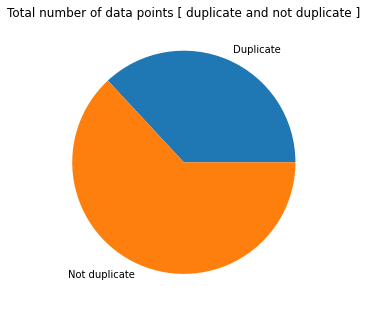

In [ ]:
plt.figure(figsize=(5, 10))
pie_data = [duplicate, not_duplicate]
labels = ["Duplicate","Not duplicate"]
plt.title("Total number of data points [ duplicate and not duplicate ]")
plt.pie(pie_data, labels=labels)
plt.show() 

In [ ]:
x = PrettyTable()
x.field_names = ["Duplicate", "Not Dupliacte"]

for i in range(0,1):
    x.add_row([duplicate,not_duplicate])
print(x)

+-----------+---------------+
| Duplicate | Not Dupliacte |
+-----------+---------------+
|   149263  |     255027    |
+-----------+---------------+


In [ ]:
print('\n~> Question pairs are Similar (is_duplicate = 0):\n   {}%'.format(round(data['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(100 - data['is_duplicate'].mean()*100, 2)))


~> Question pairs are Similar (is_duplicate = 0):
   36.92%

~> Question pairs are Similar (is_duplicate = 1):
   63.08%


__Data set is unbalanced__

In [ ]:
# Number of unique questions 
unique_questions = len(pd.unique(data[['qid1', 'qid1']].values.ravel()))

In [ ]:
data.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
data[data['qid1'] == 3]

,id,qid1,qid2,question1,question2,is_duplicate
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
184732,184732,3,282170,What is the story of Kohinoor (Koh-i-Noor) Dia...,Is it possible to melt down diamonds?,0
263614,263614,3,380197,What is the story of Kohinoor (Koh-i-Noor) Dia...,What are some interesting facts about Kohinoor...,0
359232,359232,3,488853,What is the story of Kohinoor (Koh-i-Noor) Dia...,Could India keep the Koh-I-Noor safe?,0


In [ ]:
data['qid1'].value_counts()

8461      50
14110     48
25984     47
20628     47
1749      47
          ..
415339     1
411241     1
413288     1
409190     1
524288     1
Name: qid1, Length: 290654, dtype: int64

In [ ]:
quid1_ = data['qid1'].value_counts().tolist()
quid2_ = data['qid2'].value_counts().tolist()
total = pd.Series(quid1_ + quid2_)
res = [i for i in total if i != 1] 
print(len(res))

99704


In [ ]:
len(data[data['qid1'] == 8461])

50

In [ ]:
qids = pd.Series(data['qid1'].tolist() + data['qid2'].tolist())
qids

0              1
1              3
2              5
3              7
4              9
           ...  
808575    379845
808576    155606
808577    537929
808578    537931
808579    537933
Length: 808580, dtype: int64

In [ ]:
np.sum(qids.value_counts() > 1)

111780

In [ ]:
qids = pd.Series(data['qid1'].tolist() + data['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
#print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



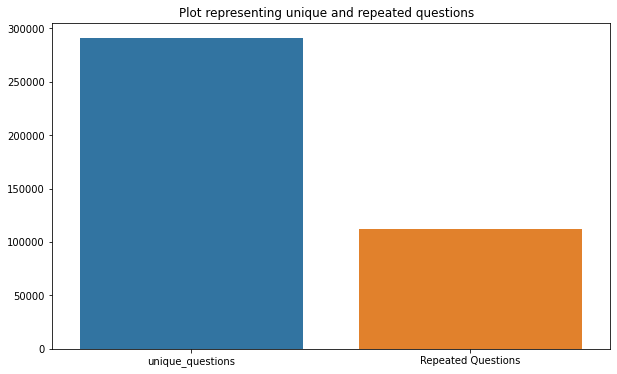

In [ ]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_questions , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

In [ ]:
#checking whether there are any repeated pair of questions

pair_duplicates = data[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print ("Number of duplicate questions",(pair_duplicates).shape[0] - data.shape[0])

Number of duplicate questions 0


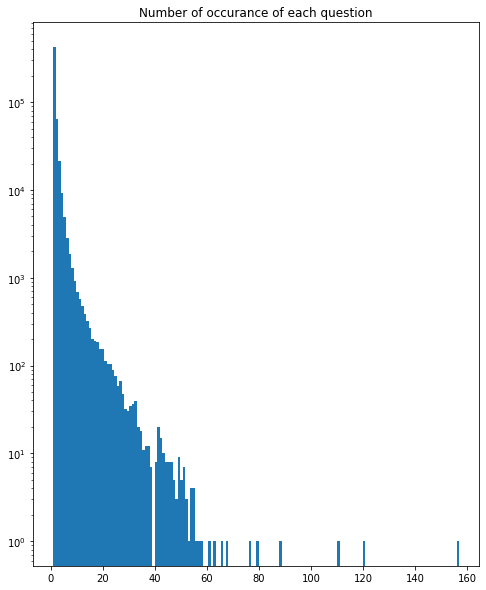

In [ ]:
# Number of occurrences of each question

qids = pd.Series(data['qid1'].tolist() + data['qid2'].tolist())
plt.figure(figsize=(8,10))
plt.title("Number of occurance of each question")
plt.hist(qids.value_counts(), bins=160)
plt.yscale('log', nonposy='clip')
plt.show()

# 2.2 Checking for NULL values

In [ ]:
#Checking whether there are any rows with null values
nan_rows = data[data.isnull().any(1)]
print(nan_rows)

            id  ...  is_duplicate
105780  105780  ...             0
201841  201841  ...             0
363362  363362  ...             0

[3 rows x 6 columns]


There are three nan value rows

In [ ]:
# Filling the null values with ' '
data = data.fillna('')
nan_rows = data[data.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [ ]:
data.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


# 2.3 feature extraction

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____lenq1____ = Length of q1
 - ____lenq2____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [ ]:
 #data['qid1'].value_counts()
 data[data['id']==0].value_counts()

id  qid1  qid2  question1                                                           question2                                                  is_duplicate
0   1     2     What is the step by step guide to invest in share market in india?  What is the step by step guide to invest in share market?  0               1
dtype: int64

In [ ]:
# counting total occurance 
feature_df = pd.DataFrame(data) 
feature_df['freq_qid1'] = data.groupby('qid1')['qid1'].transform('count')
feature_df['freq_qid2'] = data.groupby('qid2')['qid2'].transform('count')
# length of question 1 and question 2
feature_df['lenq1']= data['question1'].str.len() 
feature_df['lenq2'] = data['question2'].str.len()
# word count of question 1 and question 2
feature_df['q1_n_words'] = data['question1'].apply(lambda row: len(row.split(" ")))
feature_df['q2_n_words'] = data['question2'].apply(lambda row: len(row.split(" ")))

feature_df.head(5)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,lenq1,lenq2,q1_n_words,q2_n_words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7


In [ ]:
l1 = ['What is the step by step guide to invest in share market', 'What is the story of Kohinoor', 'How can I increase the speed of my internet connection while using a VPN?']
l2 = ['What is the step by step guide to invest in indian share market', 'What would happen if the Indian government stole diamond', 'How can Internet speed be increased by hacking through DNS?']

# common words counts
def common_words(Q1,Q2):
  word_Common = []
  for i in tqdm(range(0, len(Q1))):
    sentence1 = Q1[i]
    sentence2 = Q2[i]
    words_sentence1 = sentence1.split()
    words_sentence2 = sentence2.split()
    common_words = [value for value in words_sentence1 if value in words_sentence2] 
    word_Common.append(len(common_words))
  return word_Common
  #print(word_Common)

In [ ]:
Q1 = data['question1'].tolist()
Q2 = data['question2'].tolist()
total_common_words = common_words(Q1, Q2)
print(total_common_words)

# adding to the database
feature_df['word_Common'] = total_common_words

100%|██████████| 404290/404290 [00:02<00:00, 201922.39it/s]


[12, 4, 3, 0, 2, 7, 0, 4, 6, 3, 1, 4, 5, 5, 26, 4, 3, 1, 5, 7, 3, 1, 4, 0, 0, 13, 3, 0, 7, 6, 6, 3, 11, 1, 5, 4, 10, 5, 4, 1, 0, 7, 8, 6, 13, 3, 0, 4, 8, 2, 3, 9, 0, 8, 0, 0, 1, 4, 10, 1, 0, 6, 6, 5, 7, 1, 5, 3, 2, 0, 5, 5, 6, 4, 14, 7, 1, 5, 2, 5, 5, 5, 5, 3, 7, 3, 18, 4, 7, 12, 4, 4, 4, 2, 2, 4, 0, 1, 11, 1, 8, 2, 9, 5, 7, 3, 0, 6, 8, 6, 6, 8, 0, 4, 3, 5, 6, 3, 12, 3, 3, 2, 5, 6, 0, 5, 4, 5, 6, 5, 1, 0, 3, 4, 5, 4, 5, 3, 2, 3, 4, 1, 1, 6, 3, 9, 1, 10, 6, 2, 0, 5, 7, 4, 1, 3, 6, 1, 5, 5, 5, 5, 5, 4, 8, 5, 0, 3, 2, 2, 5, 3, 1, 4, 5, 6, 7, 4, 5, 3, 3, 6, 9, 3, 5, 21, 1, 4, 5, 3, 6, 4, 4, 5, 7, 5, 0, 3, 6, 9, 7, 2, 6, 3, 6, 11, 3, 4, 6, 4, 8, 4, 1, 9, 0, 6, 7, 3, 1, 5, 3, 0, 7, 2, 3, 7, 12, 2, 1, 8, 1, 3, 19, 0, 3, 4, 4, 1, 8, 3, 7, 6, 12, 6, 7, 1, 2, 2, 8, 7, 3, 5, 5, 7, 6, 3, 3, 6, 2, 1, 8, 5, 6, 5, 0, 4, 3, 8, 6, 1, 9, 1, 7, 3, 7, 6, 5, 4, 2, 2, 2, 7, 8, 3, 4, 6, 4, 7, 5, 5, 15, 8, 2, 5, 2, 10, 3, 1, 10, 4, 6, 0, 2, 2, 4, 3, 4, 5, 4, 6, 1, 5, 12, 4, 2, 3, 0, 3, 5, 4, 6, 8, 3, 1, 9, 4,

In [ ]:
l1 = ['What is the step by step guide to invest in share market', 'What is the story of Kohinoor', 'How can I increase the speed of my internet connection while using a VPN?']
l2 = ['What is the step by step guide to invest in indian share market', 'What would happen if the Indian government stole diamond', 'How can Internet speed be increased by hacking through DNS?']
# total words in Q1 and Q2
def total_words(Q1,Q2):
  word_Total = []
  Q1_length = [len(value.split()) for value in Q1]
  Q2_length = [len(value.split()) for value in Q2]
  for i in tqdm(range(len(Q1_length))):
    word_Total.append(Q1_length[i] + Q2_length[i])
  return word_Total

Q1 = data['question1'].tolist()
Q2 = data['question2'].tolist()
total_words = total_words(Q1, Q2)
print(total_words)

# adding to the database
feature_df['word_Total'] = total_words

100%|██████████| 404290/404290 [00:00<00:00, 2229112.90it/s]


[26, 21, 24, 20, 20, 32, 15, 16, 16, 18, 28, 17, 15, 13, 58, 32, 8, 20, 27, 18, 12, 16, 16, 18, 27, 29, 10, 15, 17, 20, 17, 27, 29, 26, 14, 27, 41, 62, 13, 27, 10, 15, 18, 23, 29, 18, 20, 36, 23, 10, 19, 26, 11, 22, 14, 19, 22, 17, 42, 14, 15, 27, 22, 15, 18, 20, 17, 17, 11, 31, 16, 11, 14, 25, 33, 49, 10, 32, 20, 15, 38, 27, 45, 14, 28, 14, 42, 15, 18, 26, 25, 38, 20, 10, 16, 10, 18, 10, 49, 22, 29, 16, 31, 16, 20, 27, 11, 15, 20, 33, 15, 20, 20, 13, 18, 17, 37, 24, 27, 16, 21, 26, 15, 16, 16, 21, 14, 19, 40, 14, 11, 11, 15, 19, 16, 10, 18, 18, 40, 11, 32, 13, 19, 14, 30, 20, 17, 44, 26, 24, 19, 16, 23, 19, 10, 19, 37, 19, 19, 16, 15, 56, 15, 16, 26, 18, 14, 25, 13, 38, 31, 15, 17, 26, 17, 14, 17, 25, 17, 8, 14, 16, 31, 15, 30, 44, 23, 30, 24, 24, 16, 20, 14, 27, 24, 19, 11, 17, 15, 34, 18, 46, 29, 15, 62, 37, 13, 19, 38, 8, 35, 42, 21, 20, 20, 16, 26, 14, 39, 15, 12, 10, 16, 21, 18, 32, 31, 9, 32, 27, 18, 22, 40, 17, 33, 21, 18, 20, 23, 35, 16, 63, 26, 21, 34, 18, 8, 18, 37, 27, 23, 

In [ ]:
# word_share
word_share = [x/y for x,y in zip(total_common_words, total_words)]
print(word_share[0])

# adding to the database
feature_df['word_share'] = word_share

0.46153846153846156


In [ ]:
# total frequency of qid1 and qid2
feature_df['freq_q1+q2'] = feature_df['freq_qid1']+feature_df['freq_qid2']

# freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2
feature_df['freq_q1-q2'] = abs(feature_df['freq_qid1']-feature_df['freq_qid2'])

In [ ]:
feature_df.head(5)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,lenq1,lenq2,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,12,26,0.461538,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4,21,0.190476,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,3,24,0.125000,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0,20,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2,20,0.100000,4,2


In [ ]:
# saving the dataset into new dataset
feature_df.to_csv("/content/drive/MyDrive/collab_data/Quora/feature_extraction_train.csv", index=False)

# 3.0 Analysis of some of the extracted features

new added features :
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____lenq1____ = Length of q1
 - ____lenq2____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [ ]:
# minimum length of questions (number of strings)
print("minumum length of Q1: ",min(feature_df['lenq1']))
print("minumum length of Q2: ",min(feature_df['lenq2']))

print("="*100)

# minimum number of word in questions
print("minumum number of words in Q1: ",min(feature_df['q1_n_words']))
print("minumum number of words in Q2: ",min(feature_df['q2_n_words']))

print("="*100)

# total number of questions with nimimum words 
print("total number of questions (Q1) with minimum words: ",feature_df[feature_df['q1_n_words']== 1].shape[0])
print("total number of questions (Q2) with minimum words: ",feature_df[feature_df['q2_n_words']== 1].shape[0])

print("="*100)

# maximum and minimum number of words common between two questions
print("minumum number of words between Q1 and Q2: ",min(feature_df['word_Common']))
print("maximum number of words between Q1 and Q2: ",max(feature_df['word_Common']))



minumum length of Q1:  0
minumum length of Q2:  0
minumum number of words in Q1:  1
minumum number of words in Q2:  1
total number of questions (Q1) with minimum words:  67
total number of questions (Q2) with minimum words:  24
minumum number of words between Q1 and Q2:  0
maximum number of words between Q1 and Q2:  52


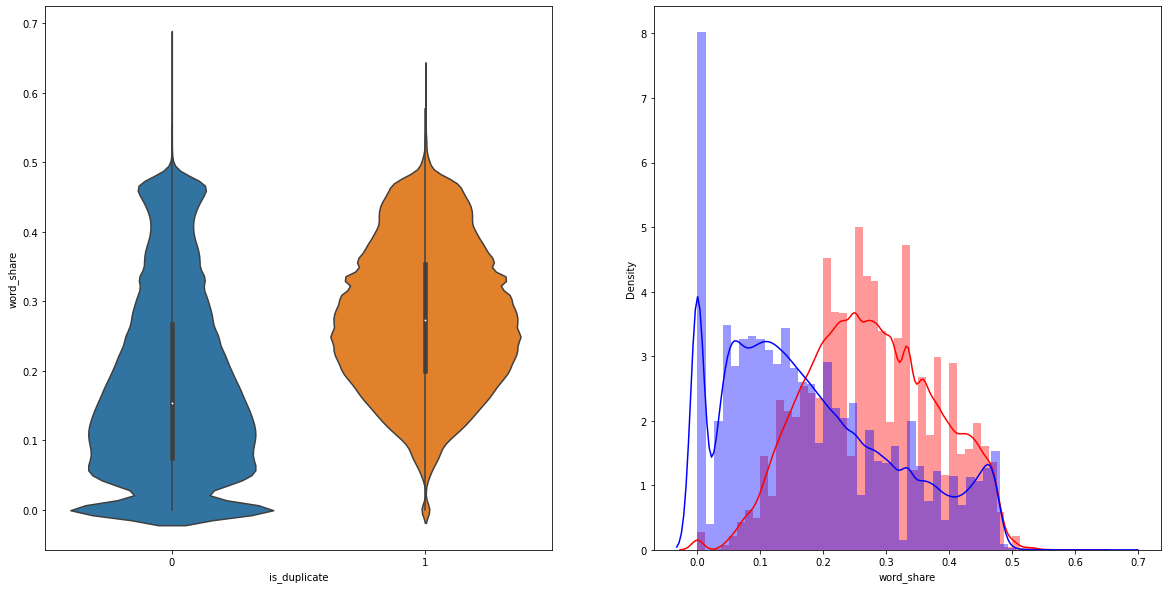

In [ ]:
# word_share vs is_dupliacte plot 

plt.figure(figsize=(20, 10))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = feature_df[0:])

plt.subplot(1,2,2)
sns.distplot(feature_df[feature_df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(feature_df[feature_df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

**LEFT graph: Both Voilen plot are not perfectly same which means word share can be used to differentiate between two class 0 and 1 (is duplicate class )**

**RIGHT graph: (PDF) has overlapping on left side , which means Q1 and Q2 have many similar words**



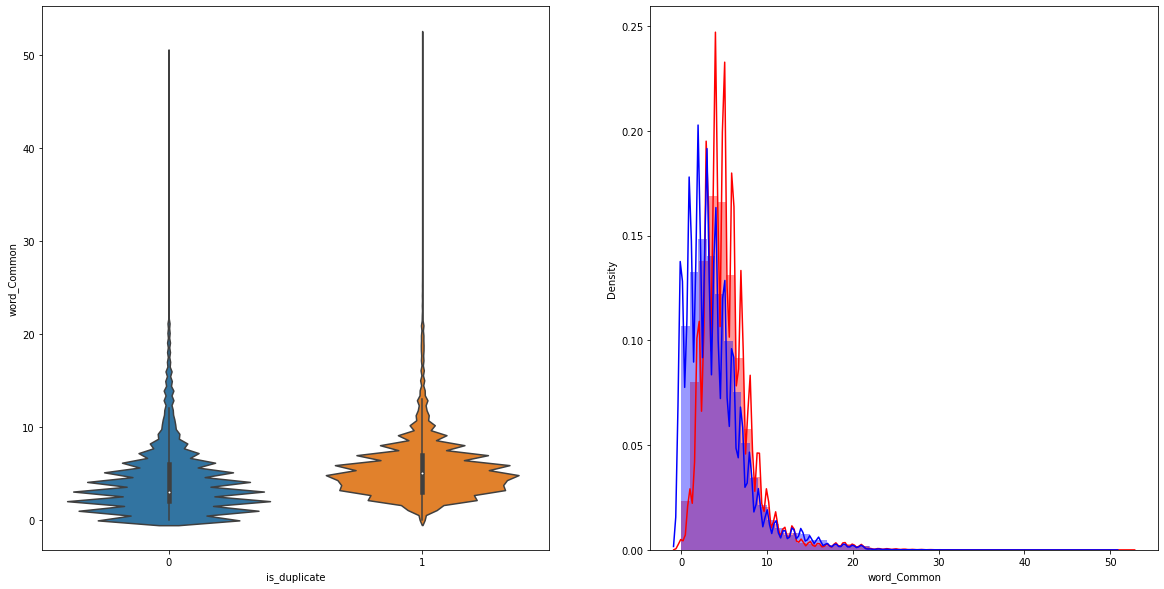

In [ ]:
# common words vs is_dupliacte plot

plt.figure(figsize=(20, 10))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = feature_df[0:])

plt.subplot(1,2,2)
sns.distplot(feature_df[feature_df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(feature_df[feature_df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

**LEFT graph: both voilent plot are mostly similar, lies around same y axis values, therefore not good for separating class 0 and 1 (is dupliacte question**

**RIGHT graph: PDF is also overlapping which means not good for separating class 0 and 1 (is dupliacte question**



---



---



In [ ]:
# next note book : text pre processing and visualizing pre processed data 